**Group Project**

## Getting the Data

https://www.kaggle.com/datasets/davidcariboo/player-scores

## Merging the Data

In [71]:
import pandas as pd
import numpy as np
import sklearn

In [72]:
#directory='C:/Users/Heidi Al Wakeel/Documents/GitHub/Football_Transfermarkt/Data/'
directory ="C:/Users/nguye/OneDrive/Documents/MMA/Winter 2023/Football_Transfermarkt/Data/"

In [73]:
# Reading CSV files into dataframes
appearances = pd.read_csv(directory+'appearances.csv')
club_games = pd.read_csv(directory+'club_games.csv')
clubs = pd.read_csv(directory+'clubs.csv')
competitions = pd.read_csv(directory+'competitions.csv')
game_events = pd.read_csv(directory+'game_events.csv')
games = pd.read_csv(directory+'games.csv')
player_valuations = pd.read_csv(directory+'player_valuations.csv')
players = pd.read_csv(directory+'players.csv')

In [74]:
# Yearly Player Game Stats
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['year'] = appearances['date'].dt.year
player_games_stats = appearances.\
    groupby(['player_id', 'year']).\
    agg(avg_game_dur = ('minutes_played', 'mean'),
        avg_games_played = ('appearance_id', 'count'),
        avg_yellow_cards = ('yellow_cards', 'mean'),
        avg_red_cards = ('red_cards', 'mean'),
        avg_goals = ('goals', 'mean'),
        avg_assists = ('assists', 'mean'),
        avg_minutes_played = ('minutes_played', 'mean')).\
    reset_index()
player_games_stats.head(1)

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played
0,10,2014.0,33.066667,15,0.133333,0.0,0.266667,0.2,33.066667


In [75]:
# Yearly Player Games Played (away & home)
player_games_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(games_played = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='games_played').\
    reset_index().\
    rename(columns={'Away': 'games_played_away', 'Home': 'games_played_home'})
player_games_home_away.head(1)

hosting,player_id,year,games_played_away,games_played_home
0,10,2014.0,7.0,8.0


In [76]:
# Yearly Player Win Percentage (away & home)
player_win_perc_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='win_perc').\
    reset_index().\
    rename(columns={'Away': 'away_win_percentage', 'Home': 'home_win_percentage'})
player_win_perc_home_away.head(1)

hosting,player_id,year,away_win_percentage,home_win_percentage
0,10,2014.0,0.285714,0.75


In [77]:
# Yearly Player Win Percentage (total)
player_win_perc = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index()
player_win_perc.head(1)

,player_id,year,win_perc
0,10,2014.0,0.533333


In [78]:
# Yearly Games Played by Competition Type
player_comp_types = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year', 'competition_type']).\
    agg(competitions_attended = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='competition_type', values='competitions_attended').\
    reset_index().\
    fillna({'domestic_cup':0, 'domestic_league':0, 'international_cup':0, 'other':0}).\
    rename(columns={'domestic_cup': 'games_player_domestic_cup', 'domestic_league': 'games_played_domestic_league',
            'international_cup': 'games_player_international_cup', 'other': 'games_played_other'})
player_comp_types.head(1)

competition_type,player_id,year,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other
0,10,2014.0,1.0,14.0,0.0,0.0


In [79]:
# Player Popularity
player_pop = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year']).\
    agg(player_avg_game_attendance = ('attendance', 'mean')).\
    reset_index()
player_pop.head(1)

,player_id,year,player_avg_game_attendance
0,10,2014.0,25929.266667


In [80]:
# Player Stats
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['year_of_birth'] = players['date_of_birth'].dt.year
player_relevant_stats = players[['player_id', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm', 'year_of_birth']]
player_relevant_stats.head(1)

,player_id,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth
0,134354,Belgium,Belgium,Aalst,Attack,Centre-Forward,Right,0,1995.0


In [81]:
# Player Valuation (Mnay NA Values because it is tracked much earlier than stats)
player_valuations['date'] = pd.to_datetime(player_valuations['date'])
player_valuations['year'] = player_valuations['date'].dt.year
player_yearly_val =player_valuations.\
    groupby(['player_id', 'year']).\
    agg(mean_market_value_in_eur = ('market_value_in_eur', 'mean'),
        max_market_value_in_eur = ('market_value_in_eur', 'max')).\
    reset_index()

In [82]:
# Final Aggregation
data = player_games_stats.\
    merge(player_games_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc, on=['player_id', 'year'], how='outer').\
    merge(player_comp_types, on=['player_id', 'year'], how='outer').\
    merge(player_pop, on=['player_id', 'year'], how='outer').\
    merge(player_yearly_val, on=['player_id', 'year'], how='outer').\
    merge(player_relevant_stats, on=['player_id'], how='left')
data['age'] = data['year'] - data['year_of_birth']
data.columns

Index(['player_id', 'year', 'avg_game_dur', 'avg_games_played',
       'avg_yellow_cards', 'avg_red_cards', 'avg_goals', 'avg_assists',
       'avg_minutes_played', 'games_played_away', 'games_played_home',
       'away_win_percentage', 'home_win_percentage', 'win_perc',
       'games_player_domestic_cup', 'games_played_domestic_league',
       'games_player_international_cup', 'games_played_other',
       'player_avg_game_attendance', 'mean_market_value_in_eur',
       'max_market_value_in_eur', 'country_of_citizenship', 'country_of_birth',
       'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm',
       'year_of_birth', 'age'],
      dtype='object')

In [83]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,max_market_value_in_eur,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth,age
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,36.0
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,37.0
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,38.0
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,5000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,34.0
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,3000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,35.0


## Feature Engineering

In [84]:
from countryinfo import countries

In [85]:
country=[]
continent=[]
for i in countries :
    country.append(i['name'])
    continent.append(i['continent'])

In [86]:
mapping=pd.DataFrame({'country_of_citizenship':country,'continent':continent})

In [87]:
data=data.merge(mapping, on='country_of_citizenship', how='left')

In [88]:
data.drop(columns=['country_of_citizenship','country_of_birth','city_of_birth'],inplace=True)

In [89]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,25929.266667,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,36.0,Europe
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,28502.472222,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,37.0,Europe
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,19311.600000,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,38.0,Europe
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,57578.411765,5000000.0,5000000.0,Goalkeeper,NaN,Left,190.0,1980.0,34.0,Europe
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,55057.333333,2000000.0,3000000.0,Goalkeeper,NaN,Left,190.0,1980.0,35.0,Europe


In [90]:
# For Imputation (Filling some null values with 0)
data = data.query('avg_games_played > 0')
#data = data.dropna(subset=['win_perc', 'mean_market_value_in_eur'])
data = data.fillna({'games_played_away': 0, 
                    'games_played_home': 0, 
                    'games_player_domestic_cup': 0, 
                    'games_played_domestic_league': 0, 
                    'games_player_international_cup': 0, 
                    'games_played_other': 0,
                    'away_win_percentage' : 0,
                    'home_win_percentage' : 0})

for col in data.columns:
    null_rows_idx = data[[col]].isnull().any(axis=1)
    if len(data[null_rows_idx]) > 0:
        print(col, data[null_rows_idx].shape)
# Output shows us which columns still have null values which we will fix/impute later in Data Cleaning

data.to_csv('data_merged.csv')

win_perc (122, 28)
mean_market_value_in_eur (2167, 28)
max_market_value_in_eur (2167, 28)
position (32, 28)
sub_position (5596, 28)
foot (1281, 28)
height_in_cm (32, 28)
year_of_birth (53, 28)
age (53, 28)
continent (11174, 28)


In [91]:
data.year_of_birth=data.year_of_birth.astype('str')

In [92]:
data['contribution_per_game']=data['avg_goals']+data['avg_assists']

## Analyzing the Data Structure

In [93]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent,contribution_per_game
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,36.0,Europe,0.466667
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,37.0,Europe,0.555556
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,1000000.0,1000000.0,Attack,Centre-Forward,Right,184.0,1978.0,38.0,Europe,0.650000
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,5000000.0,5000000.0,Goalkeeper,NaN,Left,190.0,1980.0,34.0,Europe,0.000000
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,2000000.0,3000000.0,Goalkeeper,NaN,Left,190.0,1980.0,35.0,Europe,0.000000


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64924 entries, 0 to 64923
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_id                       64924 non-null  int64  
 1   year                            64924 non-null  float64
 2   avg_game_dur                    64924 non-null  float64
 3   avg_games_played                64924 non-null  float64
 4   avg_yellow_cards                64924 non-null  float64
 5   avg_red_cards                   64924 non-null  float64
 6   avg_goals                       64924 non-null  float64
 7   avg_assists                     64924 non-null  float64
 8   avg_minutes_played              64924 non-null  float64
 9   games_played_away               64924 non-null  float64
 10  games_played_home               64924 non-null  float64
 11  away_win_percentage             64924 non-null  float64
 12  home_win_percentage             

In [95]:
data.describe()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,height_in_cm,age,contribution_per_game
count,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,...,64924.000000,64924.000000,64924.000000,64924.000000,64924.000000,6.275700e+04,6.275700e+04,64892.000000,64871.000000,64924.000000
mean,201168.041957,2017.933692,63.651873,15.982965,0.140592,0.003807,0.074128,0.056940,63.651873,8.023335,...,1.046916,13.723415,1.166656,0.045977,14400.010437,3.874549e+06,4.394323e+06,180.097793,25.905227,0.131068
std,161988.736461,2.465908,24.158194,11.637990,0.155056,0.025462,0.131111,0.095831,24.158194,5.932188,...,1.378357,10.001174,2.546848,0.254883,12958.278553,8.994894e+06,9.949812e+06,20.483944,4.535568,0.182305
min,10.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+04,1.000000e+04,0.000000,15.000000,0.000000
25%,64992.000000,2016.000000,48.102586,6.000000,0.000000,0.000000,0.000000,0.000000,48.102586,3.000000,...,0.000000,5.000000,0.000000,0.000000,4345.424242,4.000000e+05,4.500000e+05,177.000000,22.000000,0.000000
50%,164912.500000,2018.000000,69.882353,14.000000,0.111111,0.000000,0.000000,0.000000,69.882353,7.000000,...,1.000000,13.000000,0.000000,0.000000,10650.525000,1.000000e+06,1.000000e+06,182.000000,26.000000,0.066667
75%,292357.000000,2020.000000,84.111111,24.000000,0.214286,0.000000,0.103448,0.090909,84.111111,12.000000,...,2.000000,20.000000,0.000000,0.000000,20633.825000,3.166667e+06,3.600000e+06,187.000000,29.000000,0.200000
max,987700.000000,2022.000000,120.000000,59.000000,2.000000,1.000000,3.000000,2.000000,120.000000,31.000000,...,11.000000,44.000000,19.000000,5.000000,83439.000000,2.000000e+08,2.000000e+08,206.000000,44.000000,3.000000


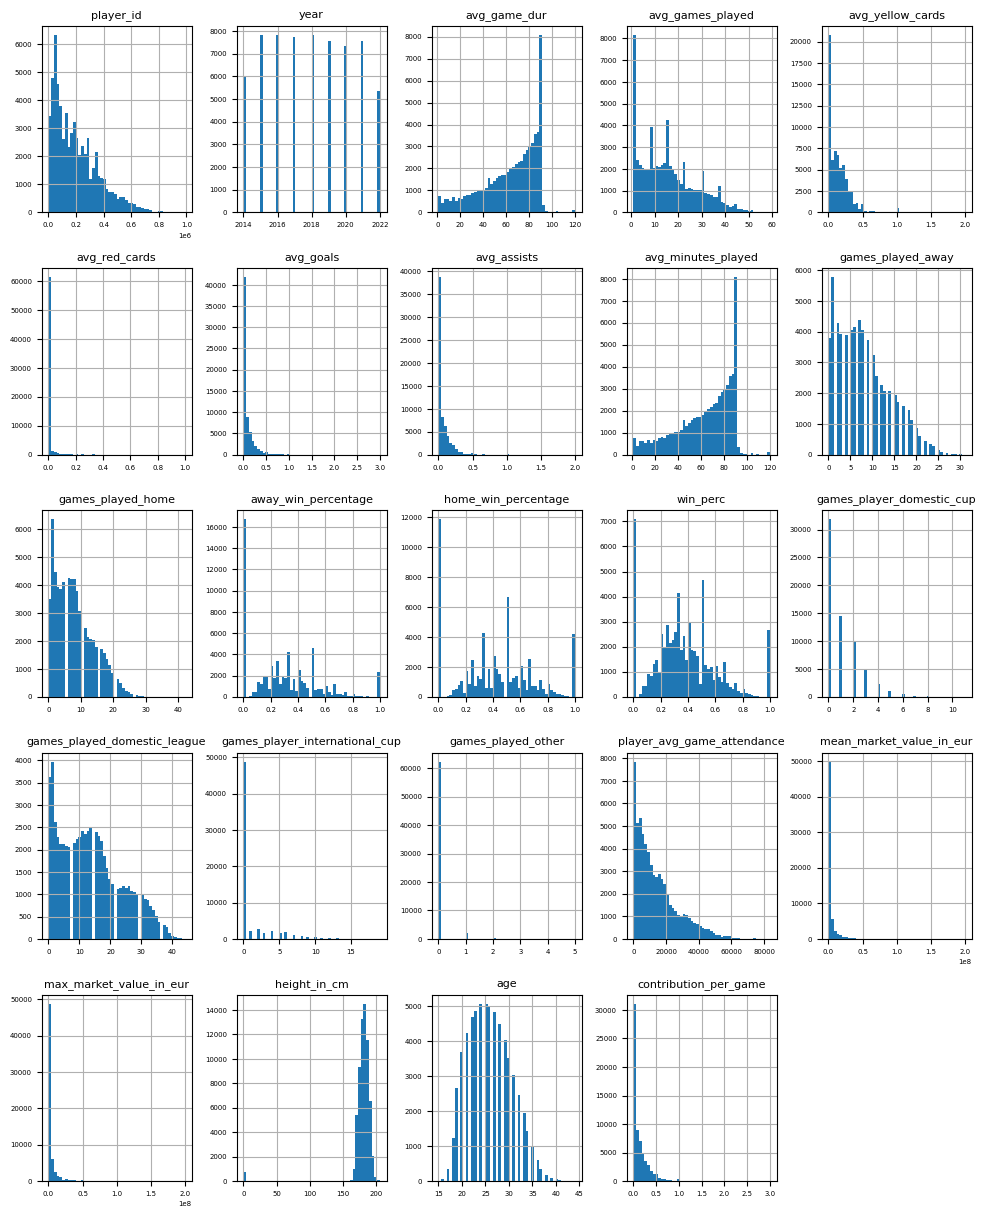

In [96]:
import matplotlib.pyplot as plt

plt.rc('font', size = 5)
plt.rc('axes', labelsize = 5, titlesize = 8)
plt.rc('legend', fontsize = 5)
plt.rc('xtick', labelsize = 5)
plt.rc('ytick', labelsize = 5)

data.hist(bins = 50, figsize = (12, 15))
plt.show()

Many variables are skewed to the left/right, meaning that they extend on the left/right of the median. This can make it difficult for our model to identify patterns. Later, we will transform these attributes to have normal distributions.

# Preparing the Data for Machine Learning Algorithms

## Data Cleaning

In [97]:
null_rows_idx = data.isnull().any(axis=1)
data.loc[null_rows_idx].head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent,contribution_per_game
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.0,0.0,90.000000,10.0,...,5.000000e+06,5000000.0,Goalkeeper,NaN,Left,190.0,1980.0,34.0,Europe,0.0
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.0,0.0,90.000000,11.0,...,2.000000e+06,3000000.0,Goalkeeper,NaN,Left,190.0,1980.0,35.0,Europe,0.0
5,26,2016.0,92.000000,15.0,0.066667,0.0,0.0,0.0,92.000000,9.0,...,1.000000e+06,1000000.0,Goalkeeper,NaN,Left,190.0,1980.0,36.0,Europe,0.0
6,26,2017.0,60.333333,3.0,0.000000,0.0,0.0,0.0,60.333333,1.0,...,9.166667e+05,1000000.0,Goalkeeper,NaN,Left,190.0,1980.0,37.0,Europe,0.0
7,26,2018.0,1.000000,1.0,0.000000,0.0,0.0,0.0,1.000000,1.0,...,NaN,NaN,Goalkeeper,NaN,Left,190.0,1980.0,38.0,Europe,0.0


In [98]:
null_counts = data.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 17932 rows with null values in the dataset.


## Advanced Imputation

In [99]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

num_cols = ['win_perc','age','height_in_cm','mean_market_value_in_eur','max_market_value_in_eur']
imputer = IterativeImputer()
imputed = imputer.fit_transform(data[num_cols])
data.loc[:, num_cols] = imputed

In [100]:
from sklearn.impute import SimpleImputer

# create an imputer that uses the most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')

cat_cols=['continent','year_of_birth','foot','position']

# fit the imputer on the data frame
imputer.fit(data[cat_cols])

# transform the data frame
data[cat_cols] = imputer.transform(data[cat_cols])

In [101]:
# Filling in missing sub_position values

# Grouping sub_position by position
sub_positions_by_position = data.groupby('position')['sub_position'].apply(list)

# Finding the most frequent sub_position for each position
sub_positions_count_by_position = sub_positions_by_position.apply(lambda x: pd.Series(x).value_counts()).fillna(0).astype(int)
sub_positions_count_by_position_dict = sub_positions_count_by_position.to_dict()

# Finding the most frequent sub_position for each position
most_frequent_sub_positions_by_position = sub_positions_count_by_position.idxmax(axis=1)

# Creating a new DataFrame with position and most frequent sub_position columns
df = pd.DataFrame({'position': most_frequent_sub_positions_by_position.index,
                   'most_frequent_sub_position': most_frequent_sub_positions_by_position.values})

df

,position,most_frequent_sub_position
0,Attack,Centre-Forward
1,Defender,Centre-Back
2,Goalkeeper,Centre-Forward
3,Midfield,Central Midfield


In [102]:
df_merged = df.merge(sub_positions_count_by_position, left_on='position', right_index=True)
most_frequent_sub_positions_dict = df_merged.set_index('position')['most_frequent_sub_position'].to_dict()

# Replace sub_position null values with most frequent sub_positions for their corresponding positions
data['sub_position'] = data.apply(lambda row: most_frequent_sub_positions_dict[row['position']] if pd.isnull(row['sub_position']) else row['sub_position'], axis=1)

In [103]:
# Just to be sure that all worked, count the number of null values in the sub_position column
num_null_values = data['sub_position'].isnull().sum()

print(f"There are {num_null_values} null values in the sub_position column")

There are 0 null values in the sub_position column


In [104]:
# Just to make sure eveyrthing worked
null_counts = data.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 0 rows with null values in the dataset.


## Handling Text and Categorical Attributes

In [105]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

## Entity Embedding

In [106]:
cat_cols=['continent','position','sub_position']

for i in cat_cols:  
    
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])

    # Define the number of categories and the embedding size
    num_categories = data[i].nunique()
    embedding_dim = data[i].nunique()//2

    # Create a tensor of categorical values
    categorical_column = torch.randint(low=0, high=num_categories, size=(len(data[i]),))

    # Create the embedding layer
    embedding_layer = nn.Embedding(num_embeddings=num_categories, embedding_dim=embedding_dim)

    # Apply the embedding layer to the categorical column
    embedded_column = embedding_layer(categorical_column)

    embedded_df = pd.DataFrame(embedded_column.detach().numpy(), columns=[i+f'_embed_{j}' for j in range(embedding_dim)])

    # Replace the original categorical column with the embedded DataFrame
    data = pd.concat([data.drop(i, axis=1), embedded_df], axis=1)

## One Hot Encoding

In [107]:
data.drop(columns='year_of_birth',inplace=True)
dummy_vars = pd.get_dummies(data['foot'],drop_first=True,prefix='foot')

data = pd.concat([data, dummy_vars], axis=1)
data.drop(columns='foot',inplace=True)

# Eliminate the ID columns

In [108]:
data = data.drop(columns = "player_id")

# Clustering

In [109]:
y = data['mean_market_value_in_eur']
X = data.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur'])


## DBSCAN

In [110]:
## Find the optimal number of eps
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = 5).fit(X_std)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(X_std)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

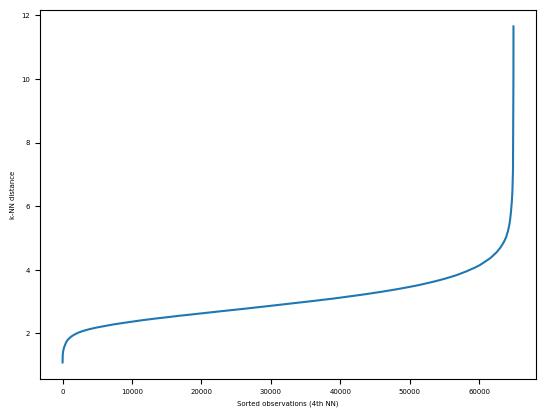

In [111]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [112]:
from sklearn.cluster import DBSCAN

#Try eps = 3
dbscan = DBSCAN(eps=3, min_samples=4)
clusters = dbscan.fit(X_std)
labels = clusters.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

150

In [113]:
#Try eps = 4
dbscan = DBSCAN(eps=4, min_samples=4)
clusters = dbscan.fit(X_std)
labels = clusters.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_


28

In [114]:
#Try eps = 5
dbscan = DBSCAN(eps=5, min_samples=4)
clusters = dbscan.fit(X_std)
labels = clusters.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_
from collections import Counter
Counter(clusters.labels_)

Counter({0: 63695,
         1: 689,
         -1: 476,
         8: 7,
         3: 7,
         6: 23,
         2: 5,
         4: 6,
         5: 12,
         7: 4})

In [115]:
# Add cluster labels to the dataset
data['cluster_label'] = labels

## Data Leakage Analysis

Analyse how the performance changes between train, validation and test set - Rohana/Hai

Do post modelling

### Split data

In [116]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set,valid_set=split_train_test(data,0.3)
print("The length of train set is: ",len(train_set))
print("The length of valid set is: ",len(valid_set))



The length of train set is:  45447
The length of valid set is:  19477


In [117]:
valid_set,test_set=split_train_test(valid_set,0.4)
print("The length of valid set is: ",len(valid_set))
print("The length of test set is: ",len(test_set))
train_set.shape, test_set.shape

The length of valid set is:  11687
The length of test set is:  7790


((45447, 37), (7790, 37))

In [118]:
#Separate Features and Target
y_test = test_set['mean_market_value_in_eur']
X_test = test_set.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur'])


Separate Predictors and Target Variable


In [119]:
y_train = train_set['mean_market_value_in_eur']
X_train = train_set.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur']) ##taking anything related to market value to avoid data leakage
y_valid = valid_set['mean_market_value_in_eur']
X_valid= valid_set.drop(columns=['mean_market_value_in_eur','max_market_value_in_eur']) ##t

Standardize Data

In [120]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)
#X_std = sc.fit_transform(X)
#X_std = pd.DataFrame(X_std,columns = X.columns)
X_valid_std = pd.DataFrame(X_valid_std,columns = X_valid.columns)
X_train_std = pd.DataFrame(X_train_std,columns = X_train.columns)
X_test_std = pd.DataFrame(X_test_std,columns = X_test.columns)


In [121]:
from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(random_state=0)
model = randomforest.fit(X_train_std,y_train)
model.feature_importances_
pd.DataFrame(list(zip(X_train.columns,model.feature_importances_)), columns=['predictor', 'feature importance']).sort_values("feature importance")


,predictor,feature importance
34,cluster_label,0.001390
33,foot_Right,0.001647
32,foot_Left,0.001656
4,avg_red_cards,0.003085
24,position_embed_0,0.003809
25,position_embed_1,0.003951
23,continent_embed_2,0.004770
22,continent_embed_1,0.005055
21,continent_embed_0,0.005709
29,sub_position_embed_3,0.006345


In [122]:
model_features = pd.DataFrame(list(zip(X_train_std.columns,model.feature_importances_)), columns = ['predictor','feature importance']).sort_values("feature importance")
model_features.tail(20)

,predictor,feature importance
28,sub_position_embed_2,0.007617
13,games_player_domestic_cup,0.008033
1,avg_game_dur,0.012345
7,avg_minutes_played,0.013112
3,avg_yellow_cards,0.014756
10,away_win_percentage,0.015859
8,games_played_away,0.016057
14,games_played_domestic_league,0.018732
6,avg_assists,0.020216
11,home_win_percentage,0.020406


## SHOULD DO Recursive Feature Elimination or so

In [124]:
from sklearn.feature_selection import RFE
rfe = RFE(randomforest, n_features_to_select = 20)
rfe.fit(X_train_std, y_train)
print(rfe.ranking_)

[ 1  1  1  1 13  1  1  1  1  1  1  1  1  3  1  1  5  1  1  1  1  9  4 11
 12 10  7  1  1  8  6  2 15 14 16]


In [125]:
# Define the feature names
feature_names = X_train_std.columns.tolist()
# Print the names of the important features
important_features = [i for i, x in enumerate(rfe.support_) if x]
selected_features = [feature_names[i] for i in important_features]
print("Important features:", selected_features)

Important features: ['year', 'avg_game_dur', 'avg_games_played', 'avg_yellow_cards', 'avg_goals', 'avg_assists', 'avg_minutes_played', 'games_played_away', 'games_played_home', 'away_win_percentage', 'home_win_percentage', 'win_perc', 'games_played_domestic_league', 'games_player_international_cup', 'player_avg_game_attendance', 'height_in_cm', 'age', 'contribution_per_game', 'sub_position_embed_1', 'sub_position_embed_2']


In [126]:
X_train_std = X_train_std[selected_features]
X_valid_std = X_valid_std[selected_features]
X_test_std = X_test_std[selected_features]

### PCA

In [136]:
from sklearn.decomposition import PCA

# Perform PCA on the training set
pca = PCA(n_components=X_train_std.shape[1])
X_train_pca = pca.fit_transform(X_train_std)

# Choose the number of components that explain at least 80% of the variance
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
n_components = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.8])
# Fit the PCA object with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)
X_valid_pca = pca.fit_transform(X_valid_std)

In [135]:
n_components

8

Text(0, 0.5, 'Second Principal Component')

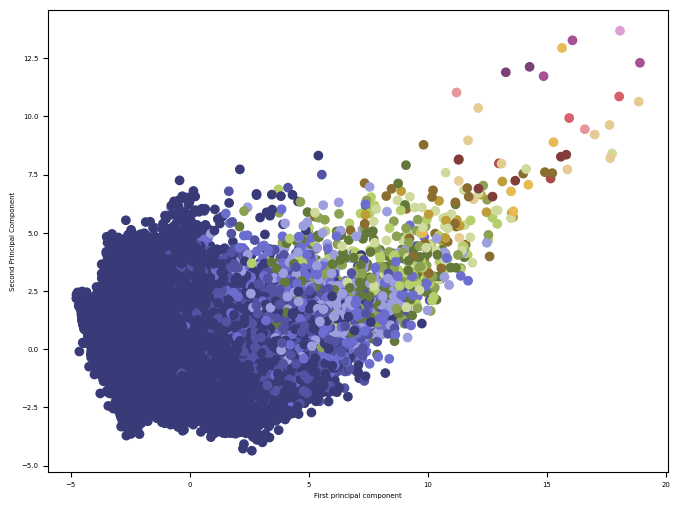

In [97]:
#from sklearn.decomposition import PCA
#scaler = StandardScaler()
#scaler.fit(train_set)
#scaled_data = scaler.transform(train_set)
#pca = PCA(n_components=2)
#pca.fit(scaled_data)
#x_pca = pca.transform(scaled_data)
#plt.figure(figsize=(8,6))
#plt.scatter(x_pca[:,0],x_pca[:,1],c=train_set['mean_market_value_in_eur'],cmap='tab20b')
#plt.xlabel('First principal component')
#plt.ylabel('Second Principal Component')

<AxesSubplot:>

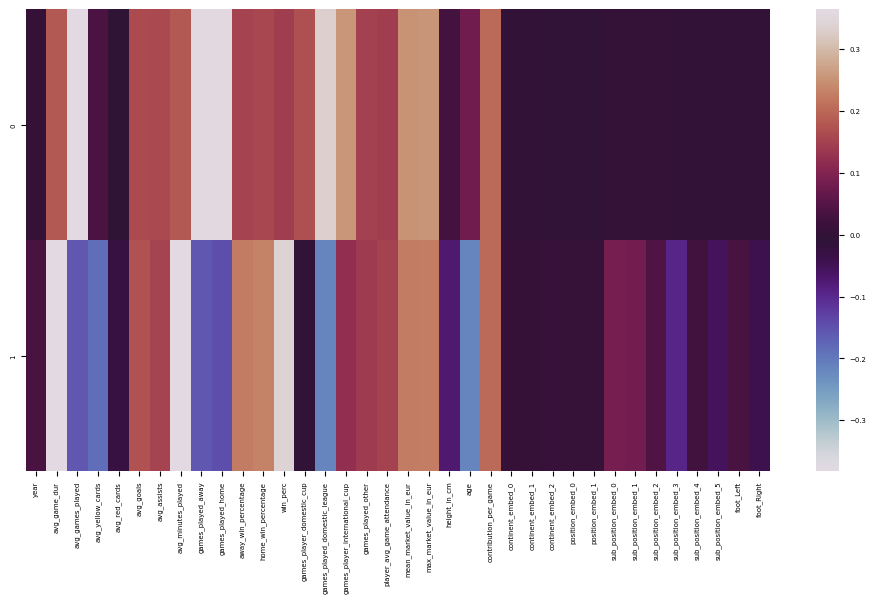

In [98]:
#import seaborn as sns
#map= pd.DataFrame(pca.components_,columns=train_set.columns)
#plt.figure(figsize=(12,6))
#sns.heatmap(map,cmap='twilight')

### Supervised Learning/ AutoML

In [99]:
# !pip install h2o
# --upgrade pip



In [100]:
import h2o
# from h2o.automl import H2OAutoML
# # initialize the h2o session
# h2o.init()
# load an h2o DataFrame from pandas DataFrame.

ModuleNotFoundError: No module named 'h2o'

In [ ]:
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

In [ ]:
train_set.to_csv('automl_train.csv')
train_set.info()

In [ ]:
df_test = h2o.import_file('automl_train.csv')

x = list(train_set.describe().columns)
x.remove('mean_market_value_in_eur')
x.remove('max_market_value_in_eur')
aml = H2OAutoML(max_models=10, seed=1)

In [ ]:
df_test

In [ ]:
pred=aml.train(x=x, y='mean_market_value_in_eur', training_frame=df_test)
lb = aml.leaderboard # Leader board
print(lb.head(rows=lb.nrows)) # print leader board

In [ ]:
valid_set.to_csv('for_automl_test.csv')


In [ ]:
test = h2o.import_file('for_automl_test.csv')
preds = aml.predict(test)

In [ ]:
preds

In [ ]:
list_model=h2o.as_list(lb.head(rows=lb.nrows)['model_id'], use_pandas=False)
import itertools

list_m = list(itertools.chain(*list_model))
list_m


### Explainability of AutoML

In [ ]:
aml.explain(test)


## Model 

5.04685e+06

#### Random Forest

In [137]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train_pca, y_train)

pred1 = rf.predict(X_valid_pca)
rf_mse = mean_squared_error(y_valid, pred1)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

6889482.5228487225

#### SVR

In [138]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train_pca, y_train)
pred2 = svm_reg.predict(X_valid_pca)


In [139]:
svm_mse = mean_squared_error(y_valid, pred2)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

9339498.39141114

#### XGBoost

In [140]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train_pca, y_train)

pred3 = xg_reg.predict(X_valid_pca)
xgbt_rmse = np.sqrt(mean_squared_error(y_valid, pred3))
xgbt_rmse


7145654.836444728

#### Gradient Boosting Tree



In [141]:
from sklearn.ensemble import GradientBoostingRegressor


gbt = GradientBoostingRegressor(random_state=0)
model2 = gbt.fit(X_train_pca,y_train)
pred4 = model2.predict(X_valid_pca)
gbt_rmse = np.sqrt(mean_squared_error(y_valid, pred4))
gbt_rmse

6900716.164129226

#### LGBM

In [142]:
from lightgbm import LGBMRegressor
# fit the model on the whole dataset
lgbm_reg_model = LGBMRegressor()
lgbm_reg_model.fit(X_train_pca, y_train)

#Testing
pred5 = lgbm_reg_model.predict(X_valid_pca)
lgbm_reg_mse = mean_squared_error(y_valid, pred5)
lgbm_reg_rmse = np.sqrt(lgbm_reg_mse)
lgbm_reg_rmse

6859078.6607494885

Text(0, 0.5, 'Models')

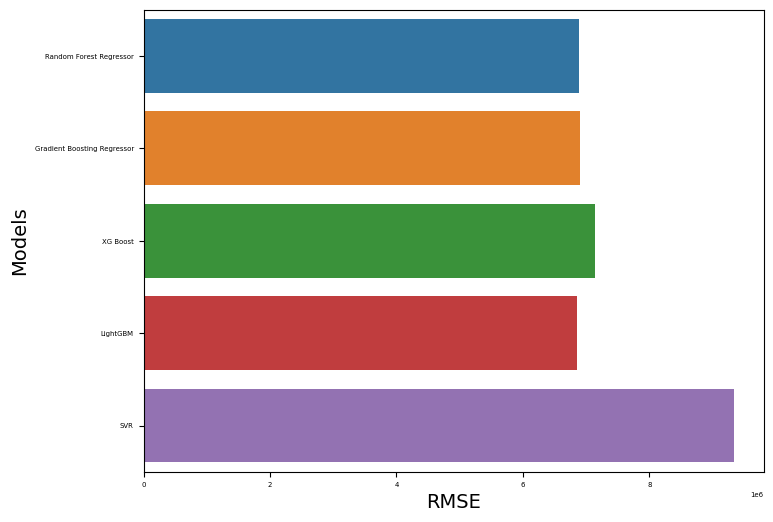

In [144]:
import seaborn as sns
df = {'Models': ["Random Forest Regressor","Gradient Boosting Regressor", 'XG Boost','LightGBM','SVR'],
     'RMSE': [rf_rmse,gbt_rmse,xgbt_rmse,lgbm_reg_rmse,svm_rmse]
     }

summary = pd.DataFrame(df)
plt.figure(figsize=(8, 6))
splot=sns.barplot(x="RMSE",y="Models",data=summary)
plt.xlabel("RMSE", size=14)
plt.ylabel("Models", size=14)

## Hyper Parameter Optimization -MLFlow

In [145]:
#!pip install mlflow


     --------------------------------------- 17.7/17.7 MB 11.9 MB/s eta 0:00:00
     ---------------------------------------- 82.7/82.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 420.6/420.6 kB 27.4 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 12.5 MB/s eta 0:00:00
     ---------------------------------------- 93.9/93.9 kB 5.6 MB/s eta 0:00:00
     ------------------------------------- 212.3/212.3 kB 13.5 MB/s eta 0:00:00
     ---------------------------------------- 147.5/147.5 kB ? eta 0:00:00
     ---------------------------------------- 184.3/184.3 kB ? eta 0:00:00
     ---------------------------------------- 57.7/57.7 kB ? eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB ? eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 8.8 MB/s eta 0:00:00
     --------------------------------------

In [146]:
#!pip install hyperopt

     ---------------------------------------- 1.6/1.6 MB 10.1 MB/s eta 0:00:00
     -------------------------------------- 200.5/200.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
# ! pip install mlflow

In [147]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from IPython.display import Image
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

search_space = {"max_depth":scope.int(hp.quniform("max_depth",2,100,5)),
                "n_estimators":scope.int(hp.quniform("n_estimators",2,100,1)),
                #"num_leaves": scope.int(hp.quniform("num_leaves",2,50,1)),
                "reg_alpha": hp.loguniform('reg_li',-5,5),
                "random_state":1,
                "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
                "min_child_weight": hp.uniform('min_child_weight', 0.5, 10),
                #"boosting": hp.choice("boosting",["gbdt","dart","goss"]),
                "objective":"reg:squarederror"
}

def train_model(parameters):
    mlflow.xgboost.autolog()
    with mlflow.start_run(nested=True):
        booster = xgb.XGBRegressor()
        booster.set_params(**parameters)
        booster.fit(X_train_std,y_train)
        
        mlflow.log_params(parameters)
        
        score = cross_val_score(booster, X_train_std, y_train, cv=5, 
                               scoring = "neg_mean_squared_error",n_jobs=-1)
        mean_score = np.mean(score)
        
        mlflow.log_metric('neg_mean_squared_error', mean_score)
        
        return{'status':STATUS_OK,
               "loss":-1*mean_score,
               'booster':booster.get_params}
    
with mlflow.start_run(run_name='xgboostmodel'):
    best_params = fmin(
        fn=train_model,
        space=search_space,
        algo=tpe.suggest,
        max_evals = 5,
        trials = Trials(),
        rstate=np.random.default_rng(123)
    )

2023/04/23 15:50:57 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

2023/04/23 15:51:01 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 662, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 581, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracki

 20%|██        | 1/5 [00:24<01:39, 24.94s/trial, best loss: 85634362727252.1]

2023/04/23 15:51:23 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 662, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 581, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracki

 40%|████      | 2/5 [00:37<00:53, 17.68s/trial, best loss: 29674156812498.375]

2023/04/23 15:51:59 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 662, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 581, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracki

 60%|██████    | 3/5 [02:17<01:50, 55.18s/trial, best loss: 27713948192222.22] 

2023/04/23 15:53:16 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 662, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 581, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracki

 80%|████████  | 4/5 [02:27<00:37, 37.40s/trial, best loss: 27713948192222.22]

2023/04/23 15:53:39 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 662, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\xgboost\__init__.py", line 581, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\fluent.py", line 783, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\client.py", line 1028, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\tracking\_tracki

100%|██████████| 5/5 [03:23<00:00, 40.70s/trial, best loss: 27713948192222.22]


In [150]:
# Set the name of the MLflow run
run_name = "xgboostmodel"

# Search for the run in the MLflow tracking server
runs = mlflow.search_runs(filter_string=f"run_name='{run_name}'")

Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 870, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 681, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 1096, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 1089, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\utils\file_utils.py", line 221, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.excepti

Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 870, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 681, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 1096, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 1089, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\utils\file_utils.py", line 221, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.excepti

In [149]:


# Retrieve the best run based on the lowest negative MSE score
best_run = runs.loc[runs['metrics.neg_mean_squared_error'].idxmin()]

# Retrieve the best hyperparameters from the MLflow run
best_params = eval(best_run.data.params)

# Retrieve the negative MSE score for the best hyperparameters
best_neg_mse = best_run.data.metrics['neg_mean_squared_error']

# Output the best hyperparameters and their negative MSE score
print("Best Hyperparameters:", best_params)
print("Negative Mean Squared Error:", np.abs(best_neg_mse))

Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 870, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 681, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 1096, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 1089, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\utils\file_utils.py", line 221, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.excepti

Traceback (most recent call last):
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 870, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 681, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 1096, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\store\tracking\file_store.py", line 1089, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\nguye\anaconda3\envs\MGSC662\lib\site-packages\mlflow\utils\file_utils.py", line 221, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.excepti

KeyError: 'metrics.neg_mean_squared_error'